In [1]:
from plane_cylinder_projections import *
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
%load_ext autoreload
%autoreload 2


In [67]:
n_points = 360
azimuth_coordinates_phi = torch.linspace(0, 2*torch.pi, 360).unsqueeze(0)

plane_angle = torch.tensor(
    [
        # [torch.pi/4, torch.pi/4, 0.],
        [0.8*torch.pi/2., torch.pi/4, -1.],
        [0.9*torch.pi/2., torch.pi/3, -0.5],
    ]
)
azimuth_coordinates_phi = azimuth_coordinates_phi.repeat(plane_angle.shape[0], 1)
altitude_z = intersect_plane_with_cyliner(azimuth_coordinates_phi, plane_angle)
print(altitude_z.shape)
p3D_gt = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]


torch.Size([2, 360])


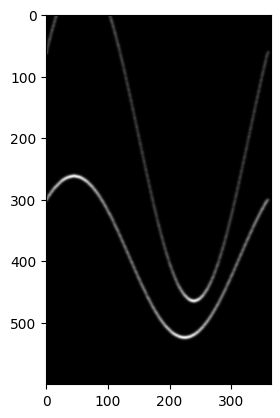

In [68]:
# splat
w = 365
h = 600
DEPTH_STEP = 0.00254
img = np.zeros((h, w), dtype=np.float32)
for batch_idx in range(altitude_z.shape[0]):
    for idx in range(altitude_z.shape[1]):
        z = altitude_z[batch_idx, idx]
        azi_deg = azimuth_coordinates_phi[batch_idx, idx]
        azi_deg = np.rad2deg(azi_deg)
        row = int(-z/DEPTH_STEP)
        if row < 0 or row >= h:
            continue

        col = int(azi_deg)
        if col < 0 or col >= w:
            continue
        # img[row-1:row+1, col-1:col+1] = 1.
        img[row, col] = 1.
img = filters.gaussian(img, sigma=2)
plt.imshow(img, cmap='gray')
plt.show()

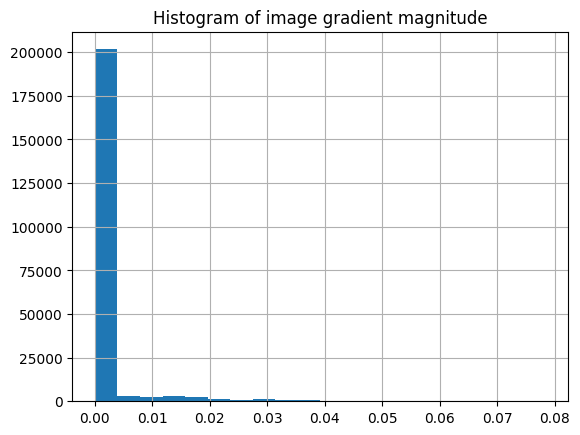

In [69]:

img_grad =filters.sobel(img)
# plt.imshow(img_grad, cmap='gray')
# plt.show()
plt.hist(img_grad.flatten(), bins=20)
plt.title('Histogram of image gradient magnitude')
plt.grid()
plt.show()

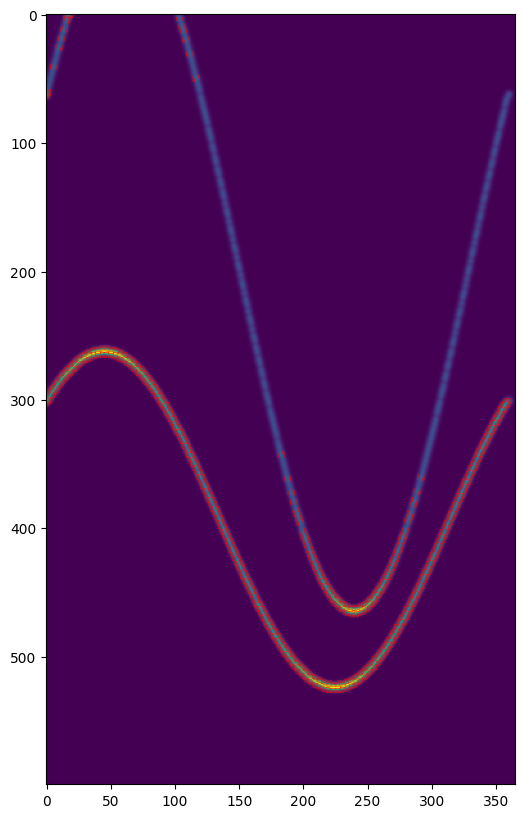

In [94]:
img_grad_v  = filters.sobel_h(img) # find the horizontal edges  =vertical gradient
img_grad_h  = filters.sobel_v(img) # find the vertical edges = horizontal gradient
high_amplitude = (img_grad > 0.02)
img_grad_h[~high_amplitude] = np.NaN
img_grad_v[~high_amplitude] = np.NaN
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.quiver(img_grad_h, img_grad_v, color="red")
plt.show()


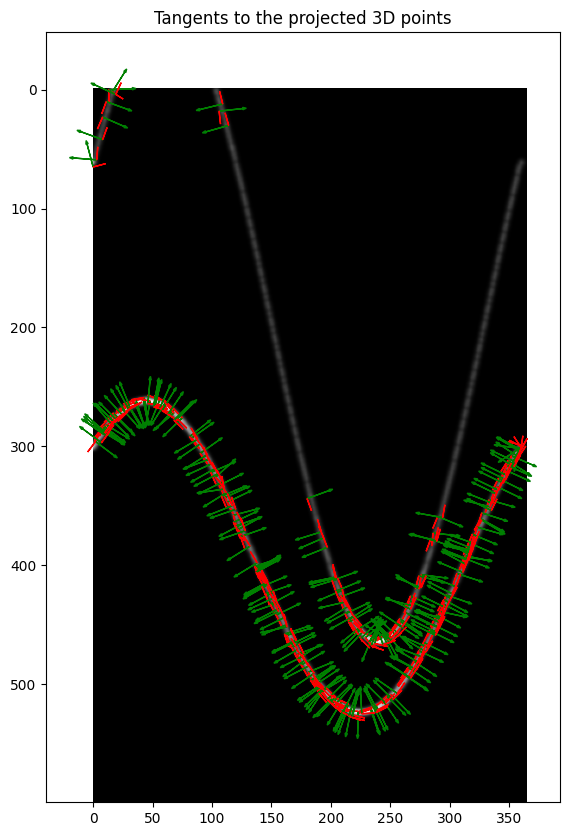

In [141]:
coords = np.array(np.where(high_amplitude)).T
gradients_image_scales = np.array([img_grad_h[high_amplitude], img_grad_v[high_amplitude]]).T
gradients_unscaled = gradients_image_scales / np.linalg.norm(gradients_image_scales, axis=1)[:, None]
tangents_unscaled = np.array([-img_grad_v[high_amplitude], img_grad_h[high_amplitude]]).T
tangents_unscaled = tangents_unscaled / np.linalg.norm(tangents_unscaled, axis=1)[:, None]
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
for coord_idx in range(coords.shape[0]):
    if coord_idx % 20 != 0:
        continue
    plt.arrow(
        coords[coord_idx, 1], coords[coord_idx, 0], 
        20.*gradients_unscaled[coord_idx, 0],
        20.*gradients_unscaled[coord_idx, 1], 
        head_width=2., head_length=3.,
        fc='b',
        ec='g'
    )
    plt.arrow(
        coords[coord_idx, 1], coords[coord_idx, 0], 
        10.*tangents_unscaled[coord_idx, 0],
        10.*tangents_unscaled[coord_idx, 1], 
        head_width=0.1, head_length=1.,
        fc='b',
        ec='r'
    )
plt.title('Tangents to the projected 3D points')
plt.show()

In [177]:
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

In [178]:
def get_tangent_vec_from_gradients(
    grad_horizontal: np.ndarray,
    grad_vertical: np.ndarray,
    scaling_horizontal_step: float = np.pi/180.,
    scaling_vertical_step: float = DEPTH_STEP,
    normalize: bool = True
) -> np.ndarray:
    """Rotate by 90° to get the tangent vector + rescale

    dI/dx = gray levels / delta pixels
    dI/d(SI unit) = dI/dx / scaling_factor

    Args:
        grad_horizontal (np.ndarray): delta gray levels / delta degrees (dazimuth°)

        grad_vertical (np.ndarray): delta gray levels / delta depth (dz)

        scaling_horizontal_step (float, optional): Scaling to go from image units to SI unit. Defaults to np.pi/180
        pi/180 * pixel step (1 horizontal pixel <-> 1 degrees =image units) = radians (SI units)

        scaling_vertical_step (float, optional): Scaling to go from image units (pixel step) to SI unit (m). Defaults to DEPTH_STEP.
        DEPTH_STEP = 0.00254 * pixel step (1 vertical pixel = 0.00254 m = image units) -> meters (SI units)

    Returns:
        np.ndarray: (N, 2) array of the tangent vectors
    """
    tangents_si_units = np.array([
        -grad_vertical/scaling_vertical_step,
        grad_horizontal/scaling_horizontal_step
    ]
    ).T
    if normalize:
        tangents_si_units = tangents_si_units / np.linalg.norm(tangents_si_units, axis=1)[:, None]
    print(tangents_si_units.shape)
    return tangents_si_units

In [179]:
tan_vec_2d = get_tangent_vec_from_gradients(img_grad_h[high_amplitude], img_grad_v[high_amplitude], normalize=False)

(5914, 2)


In [180]:
azi_list = torch.deg2rad(img_coords[:, 1]).unsqueeze(0)
alt_list = -img_coords[:, 0]*DEPTH_STEP
tangent = np.array([
    -gradients_unscaled[:, 1], # y 
    gradients_unscaled[:, 0],
]).T
tangent.shape
tangents_3d = []
for idx in range(azi_list.shape[1]):
    azi = azi_list[0, idx]
    alt = alt_list[idx]
    delta_azi = tan_vec_2d[idx, 0]
    delta_alt = tan_vec_2d[idx, 1]
    # print(azi, alt, delta_azi, delta_alt)
    tan3d = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    tan3d = tan3d / tan3d.norm()
    # print(tan3d.shape)
    tangents_3d.append(tan3d)
tangents_3d = torch.stack(tangents_3d, dim=0).unsqueeze(0)
# tangents_3d = np.array(tangents_3d)

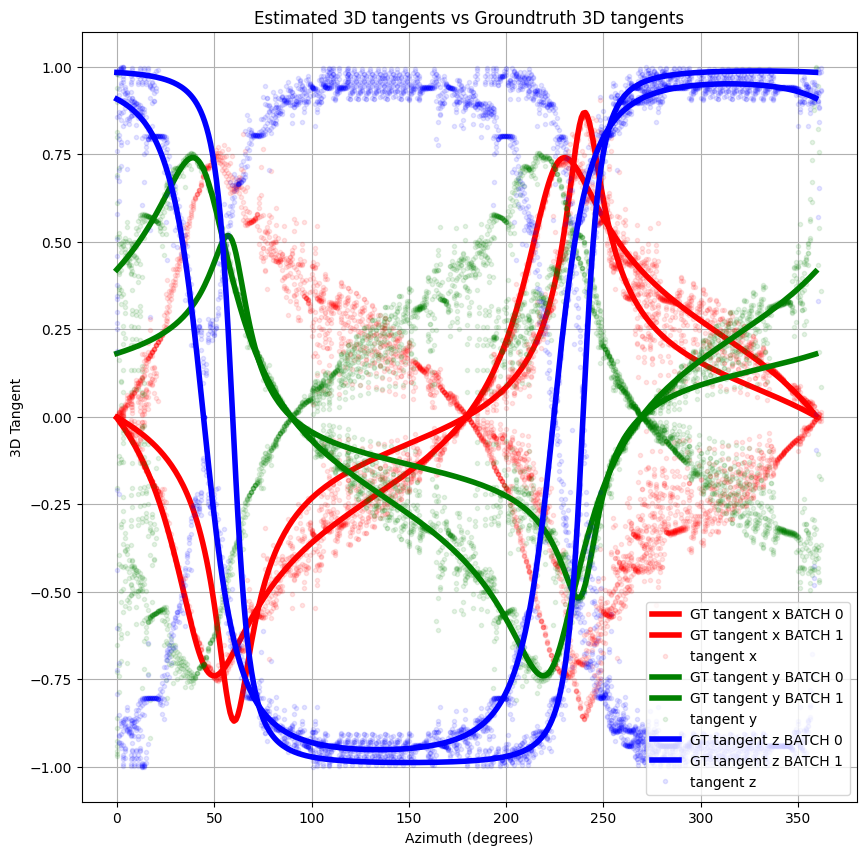

In [188]:
tangent3d = (p3D_gt[..., 1:, :] - p3D_gt[..., :-1, :])
tangent3d = tangent3d / tangent3d.norm(dim=-1, keepdim=True)
plt.figure(figsize=(10, 10))
for dim_idx, dim_name, dim_color  in zip(range(3), "xyz", "rgb"): 
    for batch_idx in range(azimuth_coordinates_phi.shape[0]):
        plt.plot(
            torch.rad2deg(azimuth_coordinates_phi[batch_idx, :-1]),
            tangent3d[batch_idx,  :, dim_idx],
            "-",
            color=dim_color,
            linewidth=4, alpha=1.,
            label=f"GT tangent {dim_name} BATCH {batch_idx}"
        )
    for batch_idx in range(azi_list.shape[0]):
        plt.plot(torch.rad2deg(azi_list[batch_idx]), -tangents_3d[batch_idx, :, dim_idx], "."+dim_color, label=f"tangent {dim_name}", alpha=0.1)
plt.xlabel("Azimuth (degrees)")
plt.ylabel("3D Tangent")
plt.legend()
plt.grid()
plt.title("Estimated 3D tangents vs Groundtruth 3D tangents")
plt.show()

In [157]:
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

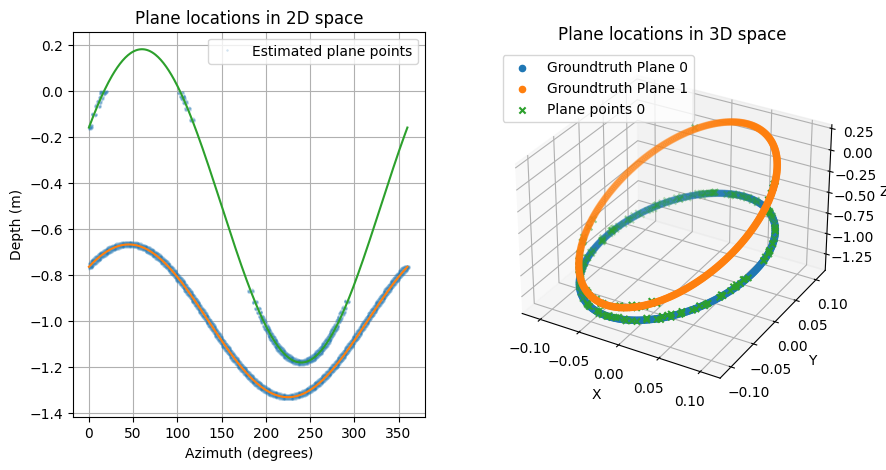

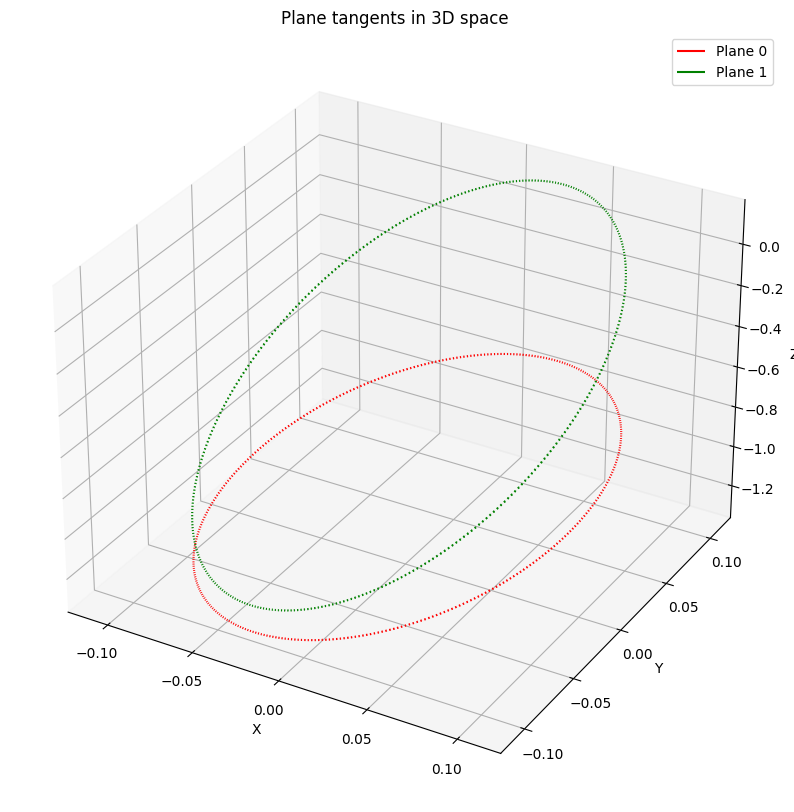

In [79]:
decim=30
# Plotting
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
# ----------------- 2D plot -----------------
ax.plot(
    torch.rad2deg(np.deg2rad(img_coords[:, 1])), 
    -img_coords[:, 0]*DEPTH_STEP, 
    "+",
    markersize=1, alpha=0.2,
    label="Estimated plane points"
)
ax.plot(torch.rad2deg(azimuth_coordinates_phi.T), altitude_z.T)
ax.set_xlabel("Azimuth (degrees)")
ax.set_ylabel("Depth (m)")
ax.grid()
ax.legend()
ax.set_title('Plane locations in 2D space')
# plt.show()

# ----------------- 3D plot -----------------

ax = fig.add_subplot(122, projection='3d')

# Extract x, y, z coordinates for plotting
for batch_index in range(p3D_gt.shape[0]):
    x_coords, y_coords, z_coords = p3D_gt[batch_index, :, 0], p3D_gt[batch_index, :, 1], p3D_gt[batch_index, :, 2]
    ax.scatter(x_coords, y_coords, z_coords, "o", label=f"Groundtruth Plane {batch_index}")
for batch_index in range(p3D_est.shape[0]):
    p3D_est_dec = p3D_est[:,  ::decim, :]
    x_coords, y_coords, z_coords = p3D_est_dec[batch_index, :, 0], p3D_est_dec[batch_index, :, 1], p3D_est_dec[batch_index, :, 2]
    ax.scatter(x_coords, y_coords, z_coords, "+", label=f"Plane points {batch_index}", marker='x')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Plane locations in 3D space')
plt.show()

# ----------------- 3D quiver -----------------
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y']
# Extract x, y, z coordinates for plotting
t3d = (p3D_gt[..., 1:, :] - p3D_gt[..., :-1, :])/3.
for batch_index in range(p3D_gt.shape[0]):
    x_coords, y_coords, z_coords = p3D_gt[batch_index, :-1, 0], p3D_gt[batch_index, :-1, 1], p3D_gt[batch_index, :-1, 2]
    tangent3d_x, tangent3d_y, tangent3d_z = t3d[batch_index, :, 0], t3d[batch_index, :, 1], t3d[batch_index, :, 2]
    ax.quiver(x_coords, y_coords, z_coords, tangent3d_x, tangent3d_y, tangent3d_z,
              color=colors[batch_index%len(colors)],
              arrow_length_ratio=0.2,
              label=f"Plane {batch_index}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
ax.set_title('Plane tangents in 3D space')
plt.show()

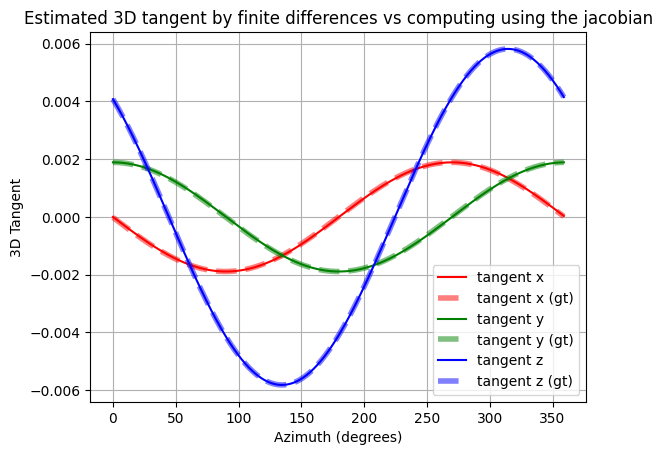

In [84]:
batch_idx, element_idx = 0, 0
# There's no obvious way to compute the jacobian per batch element, so ... loop over the elements
# There's a hacky solution proposed in pytorch forums, but it's not clear if it's correct
# https://discuss.pytorch.org/t/computing-batch-jacobian-efficiently/80771
estimated_grad_list = []
tangent3d = (p3D_gt[..., 1:, :] - p3D_gt[..., :-1, :])
for element_idx in range(azimuth_coordinates_phi.shape[1]-1):
    azi, alt = azimuth_coordinates_phi[batch_idx, element_idx], altitude_z[batch_idx, element_idx]
    delta_azi = azimuth_coordinates_phi[batch_idx, element_idx+1] - azimuth_coordinates_phi[batch_idx, element_idx]
    delta_alt = altitude_z[batch_idx, element_idx+1] - altitude_z[batch_idx, element_idx]
    estimated_grad = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    estimated_grad_list.append(estimated_grad)
estimated_grad_list = torch.stack(estimated_grad_list)
for dim_idx, dim_name, dim_color  in zip(range(3), "xyz", "rgb"):
    plt.plot(torch.rad2deg(azimuth_coordinates_phi[batch_idx,:-1]), estimated_grad_list[:, dim_idx], color=dim_color, label=f"tangent {dim_name}")
    plt.plot(torch.rad2deg(azimuth_coordinates_phi[batch_idx,:-1]), tangent3d[0,  :, dim_idx], "--", color=dim_color, linewidth=4, alpha=0.5, label=f"tangent {dim_name} (gt)")
plt.xlabel("Azimuth (degrees)")
plt.ylabel("3D Tangent")
plt.legend()
plt.grid()
plt.title("Estimated 3D tangent by finite differences vs computing using the jacobian")
plt.show()